In [2]:
%pylab inline
import pandas as pd
from sklearn import decomposition
import librosa
from  librosa.util import frame
import scipy
import IPython
from IPython.display import display, Audio
from sklearn.cluster import KMeans,DBSCAN, estimate_bandwidth, MeanShift
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../utils.py

rc_default()

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:276: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:276: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


In [3]:
path = "../wavs/"
fnames = ["Grisey_partiels.wav"]
T1 = 0
T2 = 120
# fnames = ["Stockhausen_Kontakte.wav"]
# T1 = 0
# T2 = None
# fnames = ["BeachBoys_SurfinUSA.wav"]
# T1 = 1
# T2 = 20

In [4]:
n_mfcc = 20
NFFT = 2**14
HOP = int(NFFT/4)
WIN_LENGTH = NFFT
sr = 44100


In [5]:
DESCRIPTORS = [

{'name': 'mfcc',
 'params': {'n_mfcc':n_mfcc,'sr':sr},
 'function': lambda self,y: librosa.feature.mfcc(S=Sm, **self.params).T },

{'name': 'rmse',
 'params': {},
 'function': lambda self,y: librosa.feature.rmse(S=Sm).T },

{'name': 'rolloff',
 'params': {'sr':sr},
 'function': lambda self,y: librosa.feature.spectral_rolloff(S=Sm,sr=sr).T },
    
{'name': 'centroid',
 'params': {'sr':sr},
 'function': lambda self,y: librosa.feature.spectral_centroid(S=Sm,**self.params).T },
    
{'name': 'scontrast',
 'params': {'sr':sr} ,
 'function' : lambda self,y: librosa.feature.spectral_contrast(S=Sm, **self.params).T },

{'name': 'chroma',
 'params':{} ,
 'function': lambda self, y: librosa.feature.chroma_stft(S=Sm, **self.params).T }]

In [6]:
audio = {}
df = pd.DataFrame()

for fname in fnames:
    sr, signal  = wav2audio_segment(path+fname,T1,T2)

    S = librosa.stft(signal,n_fft=NFFT, hop_length=HOP,center=False)
    Sm = abs(S)
    
    ntotal = signal.size
    durtotal = ntotal/sr
    
    normdata = []
    data = []
    multiindex = []
    
    for D in DESCRIPTORS:
        d = Descriptor(D)
        d.perform(signal)
        data.append(d.data)
        ndata = normalize(d.data,white=False)
        normdata.append(ndata)        
            
        multiindex += [ (d.name,i) for i in range(d.data.shape[1]) ]
    

/usr/local/lib/python3.4/dist-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [7]:
frames = frame(signal, frame_length=NFFT, hop_length=HOP)
t = linspace(0,HOP/float(sr)*frames.shape[1],frames.shape[1])

normframes = frames/sqrt((frames**2).mean(0))

In [8]:
columns = pd.MultiIndex.from_tuples(multiindex, names=['Descriptor', 'Feature'])
df = pd.DataFrame(np.hstack(data),columns = columns)
normdf = pd.DataFrame(np.hstack(normdata),columns = columns)

In [9]:
pca = decomposition.PCA(n_components=40)
Ypca = pca.fit_transform(normdf.values)

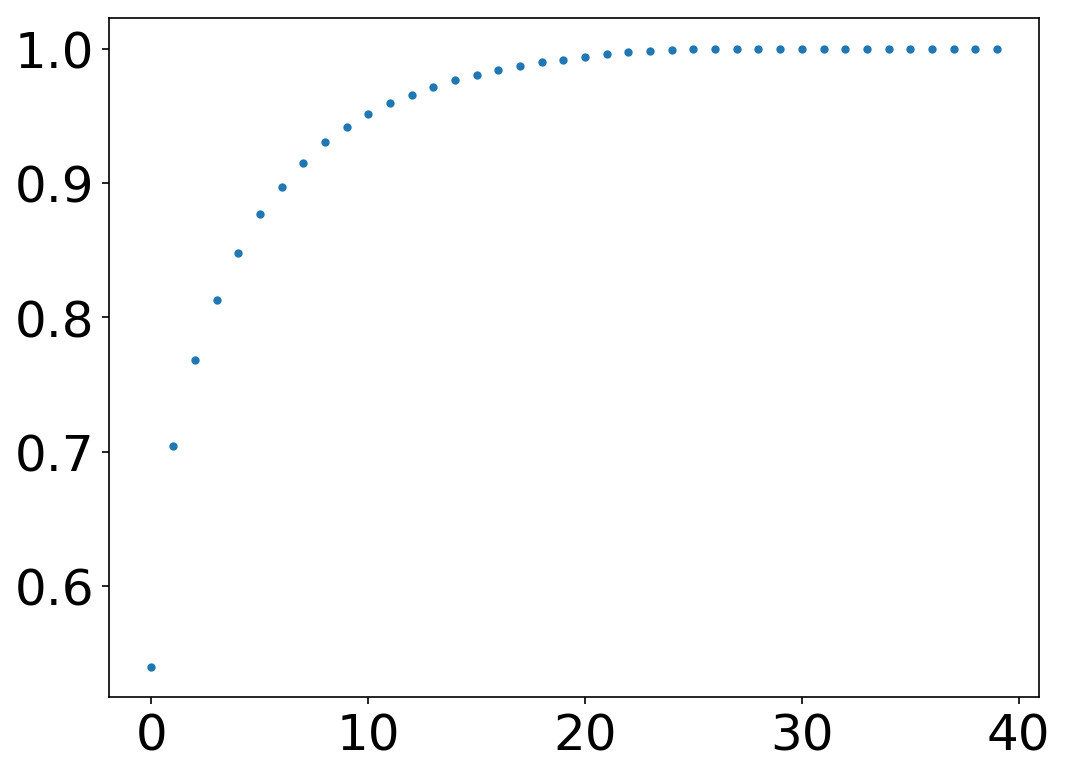

In [10]:
plot(cumsum(pca.explained_variance_ratio_),'.')
maxpca= where(cumsum(pca.explained_variance_ratio_)>0.9)[0][0]

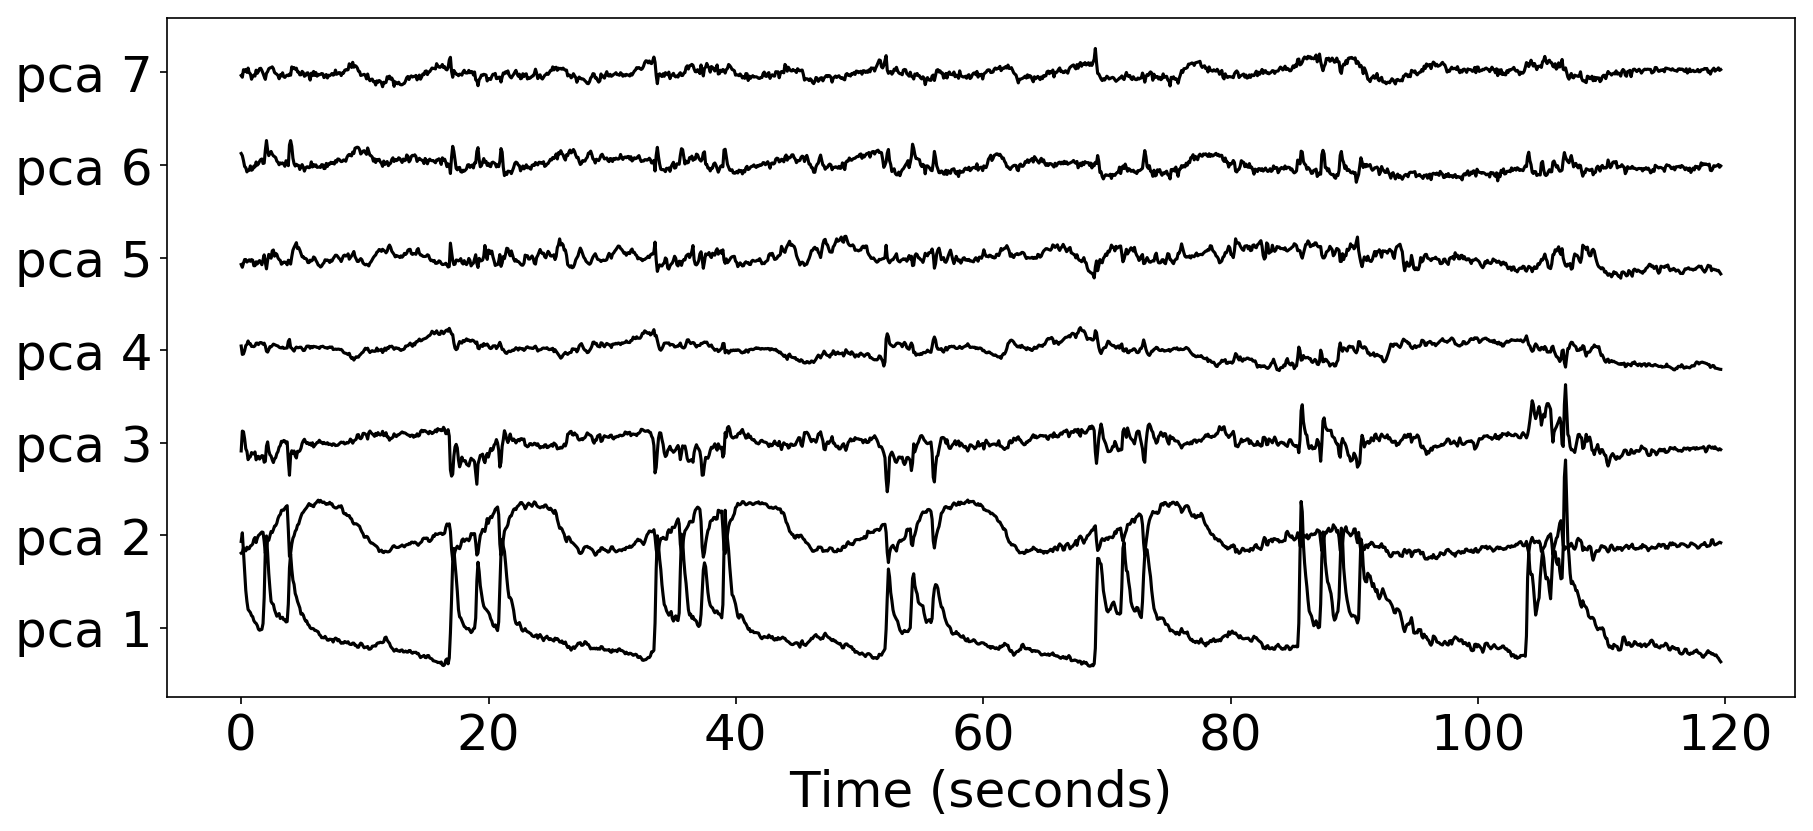

In [14]:
figure(figsize=(14,6))
Ypca = Ypca[:,:maxpca]
sep = 15
plot(t,Ypca+arange(maxpca)*sep,'k');
xlabel('Time (seconds)')
yticks(range(0,maxpca*sep,sep),['pca '+str(i+1) for i in range(maxpca)]);
savefig('../talk/figs/pca7_grisey.png')

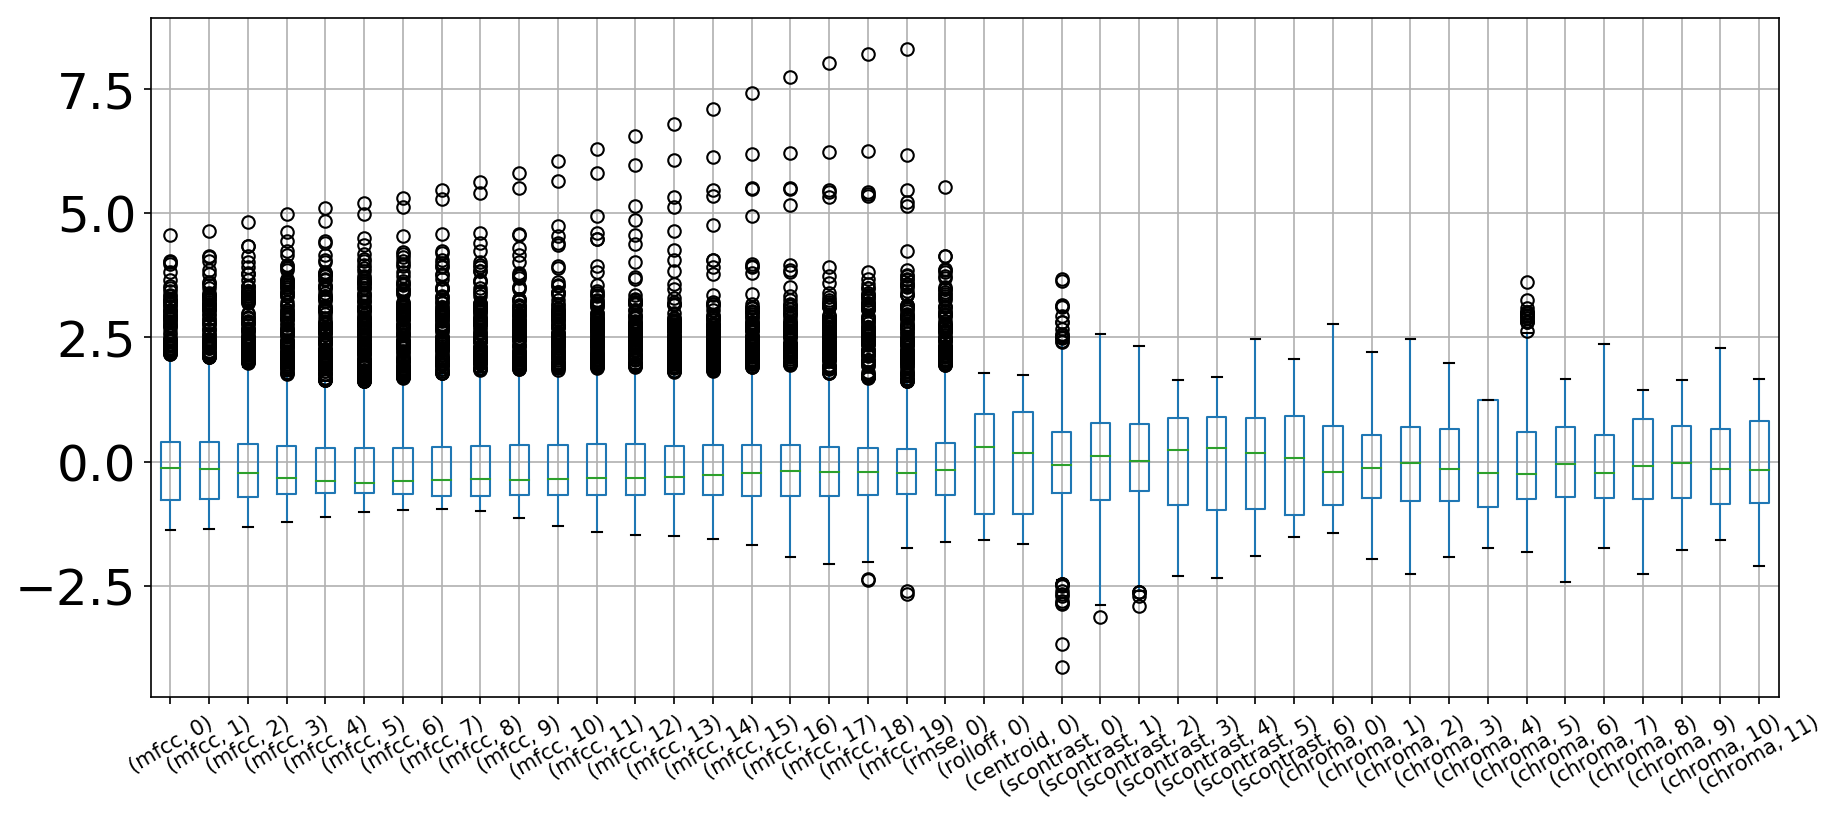

In [15]:
figure(figsize=(14,6))
normdf.boxplot();
labels = gca().get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10);

In [16]:
rec = librosa.segment.recurrence_matrix(normdf.values.T,k=1120,metric='euclidean',sym=True,mode='distance')

In [17]:
def plotfunc():
    fig,ax = plt.subplots(figsize=(12,12))
    im = imshow(rec, extent=[0,duration,0,duration],cmap=cm.viridis)
    fig.colorbar(im,fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig,ax

In [18]:
#Plotfunc should give time in seconds for x axis
duration = signal.size/sr
# audiofigure(plotfunc,duration,path+fnames[0],fps=10,figsize=(16,16),ylim=(0,duration),videoname=fnames[0][:-4]+'.mp4')

/usr/local/lib/python3.4/dist-packages/matplotlib/image.py:373: RuntimeWarning: invalid value encountered in less
  rgba[..., 1] = A < 0  # under data
/usr/local/lib/python3.4/dist-packages/matplotlib/image.py:374: RuntimeWarning: invalid value encountered in greater
  rgba[..., 2] = A > 1  # over data


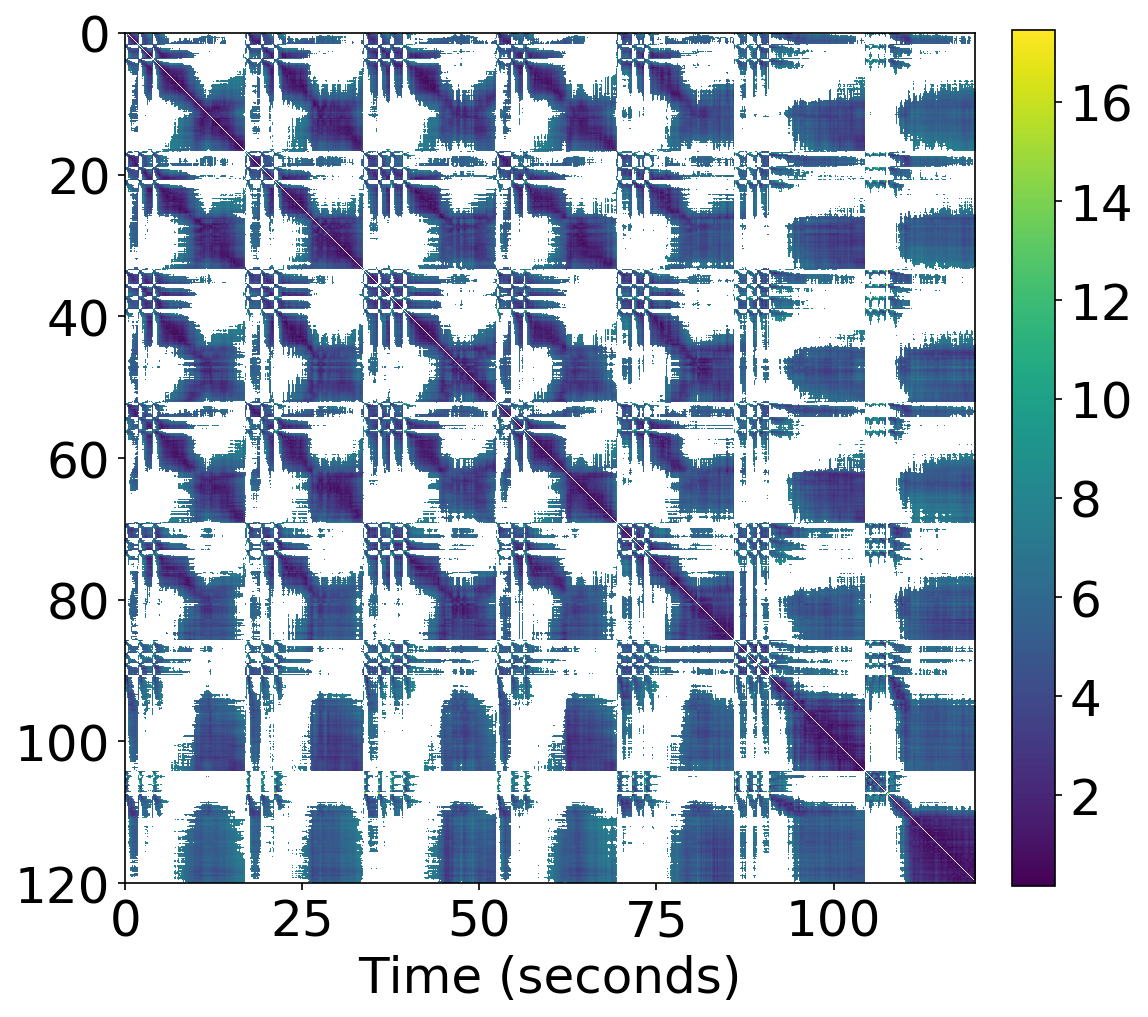

In [34]:
rec = librosa.segment.recurrence_matrix(Ypca.T,k=800,metric='euclidean',sym=True,mode='distance')
rec[rec==0]=np.nan
figure(figsize=(8,8))
im = imshow(rec, extent=[0,duration,0,duration],cmap=cm.viridis,vmin=np.nanmin(rec),vmax=np.nanmax(rec),origin='bottom');
ylim(duration,0)
xlabel('Time (seconds)');
plt.colorbar(im,fraction=0.046, pad=0.04)
# savefig('../talk/figs/reccurence_pca7_grisey.png')

In [27]:
np.nanmin

numpy.ndarray